In [1383]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import random
import os
from glob import glob
from tqdm import tqdm
import datetime
from datetime import timedelta
import copy
import zipfile

In [1384]:
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

In [1385]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error

In [1386]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.linear_model import Lars, LassoLars, OrthogonalMatchingPursuit
from sklearn.linear_model import BayesianRidge, ARDRegression, PassiveAggressiveRegressor
from sklearn.linear_model import RANSACRegressor, TheilSenRegressor, HuberRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings(action='ignore')

In [1387]:
pd.options.display.max_columns = None

In [1388]:
device = torch.device(
    'cuda') if torch.cuda.is_available() else torch.device('cpu')


In [1389]:
import argparse
parser = argparse.ArgumentParser(description="baseline")
parser.add_argument('--best_n', default=8, type=int)
parser.add_argument('--missing', default="f", type=str)  # b, f, i
# standard or minmax or robust
parser.add_argument('--scaler', default="robust", type=str)
parser.add_argument('--cv', default=10, type=int)
parser.add_argument('--seed', default=1011, type=int)
args = parser.parse_args('')

In [1390]:
best_n = args.best_n
missing = args.missing
scaler = args.scaler
cv = args.cv
seed = args.seed

In [1391]:
if scaler == "standard":
    scaler = StandardScaler()
elif scaler == "minmax":
    scaler = MinMaxScaler()
elif scaler == "robust":
    scaler = RobustScaler()

In [1392]:
seed = 42
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(seed)

## 1. 데이터 불러오기

In [1393]:
base_path = '/Users/seul/seulhub/2022_likelion_dataset/Bok_choy'


In [1394]:
train_input_files = sorted(glob(f'{base_path}/train_input/*.csv'))
train_target_files = sorted(glob(f'{base_path}/train_target/*.csv'))
train_input_files[0], train_target_files[0]


('/Users/seul/seulhub/2022_likelion_dataset/Bok_choy/train_input/CASE_01.csv',
 '/Users/seul/seulhub/2022_likelion_dataset/Bok_choy/train_target/CASE_01.csv')

In [1395]:

test_input_files = sorted(glob(f'{base_path}/test_input/*.csv'))
test_target_files = sorted(glob(f'{base_path}/test_target/*.csv'))
test_input_files[0], test_target_files[0]


('/Users/seul/seulhub/2022_likelion_dataset/Bok_choy/test_input/TEST_01.csv',
 '/Users/seul/seulhub/2022_likelion_dataset/Bok_choy/test_target/TEST_01.csv')

In [1396]:
len(train_input_files), len(train_target_files), len(test_input_files), len(test_target_files)

(58, 58, 6, 6)

### columns 동일한지 확인

In [1397]:
cols = sorted(pd.read_csv(train_input_files[0]).columns)
print(cols)

['CO2관측치', 'EC관측치', '기준온도', '난방부하', '난방상태', '난방온도', '난방작동남은시간', '내부습도관측치', '내부온도관측치', '내부유동팬상태', '내부유동팬작동남은시간', '냉방부하', '냉방상태', '냉방온도', '냉방작동남은시간', '레드 LED동작강도', '레드 LED상태', '레드 LED작동남은시간', '백색광추정광량', '블루 LED동작강도', '블루 LED상태', '블루 LED작동남은시간', '시간', '외부습도관측치', '외부온도관측치', '외부환기팬상태', '외부환기팬작동남은시간', '일간누적분무량', '적색광추정광량', '청색광추정광량', '총추정광량', '최근분무량', '카메라상태', '펌프상태', '펌프작동남은시간', '화이트 LED동작강도', '화이트 LED상태', '화이트 LED작동남은시간']


In [1398]:
file_cnts = len(train_input_files)

In [1399]:
cnt = 0
check_idx = []
for i, data in enumerate(train_input_files):
    file_cols = sorted(pd.read_csv(data).columns)
    if file_cols != cols:
        check_idx.append(i)
        cnt += 1
        # print(file_cols)
print(f'Total {file_cnts} files')
print(f"We should check columns of {cnt} files")
print(check_idx)

Total 58 files
We should check columns of 28 files
[9, 17, 29, 30, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57]


In [1400]:
feature_list = pd.read_csv(train_input_files[0]).columns
print(feature_list)
print()
print(f'=> Total {len(feature_list)} columns')

Index(['시간', '내부온도관측치', '내부습도관측치', 'CO2관측치', 'EC관측치', '외부온도관측치', '외부습도관측치',
       '펌프상태', '펌프작동남은시간', '최근분무량', '일간누적분무량', '냉방상태', '냉방작동남은시간', '난방상태',
       '난방작동남은시간', '내부유동팬상태', '내부유동팬작동남은시간', '외부환기팬상태', '외부환기팬작동남은시간',
       '화이트 LED상태', '화이트 LED작동남은시간', '화이트 LED동작강도', '레드 LED상태', '레드 LED작동남은시간',
       '레드 LED동작강도', '블루 LED상태', '블루 LED작동남은시간', '블루 LED동작강도', '카메라상태', '냉방온도',
       '난방온도', '기준온도', '난방부하', '냉방부하', '총추정광량', '백색광추정광량', '적색광추정광량',
       '청색광추정광량'],
      dtype='object')

=> Total 38 columns


## 2. 파일 하나로 합치기

In [1401]:
# 파일 하나로 합치기
def preprocess_data(input_paths, target_paths):

    idx = 0

    temp_df = pd.DataFrame()
    for input_path, target_path in tqdm(zip(input_paths, target_paths)):

        idx += 1

        input_df = pd.read_csv(input_path)
        target_df = pd.read_csv(target_path)

        input_df.columns = feature_list

        input_df["시간"] = pd.to_datetime(
            input_df["시간"]) + datetime.timedelta(days=1)
        input_df["year"] = input_df["시간"].dt.year
        input_df["month"] = input_df["시간"].dt.month
        input_df["day"] = input_df["시간"].dt.day

        target_df["시간"] = pd.to_datetime(target_df["시간"])
        target_df["year"] = input_df["시간"].dt.year
        target_df["month"] = target_df["시간"].dt.month
        target_df["day"] = target_df["시간"].dt.day

        input_df = input_df.groupby(
            by=["year", "month", "day"]).median().reset_index()
        target_df = target_df.groupby(
            by=["year", "month", "day"]).median().reset_index()

        if missing == "b":
            input_df = input_df.fillna(method='bfill')
        if missing == "f":
            input_df = input_df.fillna(method='ffill')
        if missing == "i":
            input_df = input_df.interpolate()

        input_df["time"] = np.arange(0, len(input_df))
        input_df["case"] = idx

        df = pd.merge(input_df, target_df)
        temp_df = pd.concat([temp_df, df], axis=0)

    temp_df = temp_df.reset_index(drop=True)
    return temp_df


train_df = preprocess_data(train_input_files, train_target_files)
test_df = preprocess_data(test_input_files, test_target_files)

58it [00:08,  6.60it/s]
6it [00:00,  6.17it/s]


In [1402]:
train_df.select_dtypes(include='object').columns

Index([], dtype='object')

In [1403]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 43 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           195 non-null    int64  
 1   month          195 non-null    int64  
 2   day            195 non-null    int64  
 3   내부온도관측치        195 non-null    float64
 4   내부습도관측치        195 non-null    float64
 5   CO2관측치         195 non-null    float64
 6   EC관측치          195 non-null    float64
 7   외부온도관측치        158 non-null    float64
 8   외부습도관측치        158 non-null    float64
 9   펌프상태           195 non-null    float64
 10  펌프작동남은시간       195 non-null    float64
 11  최근분무량          195 non-null    float64
 12  일간누적분무량        195 non-null    float64
 13  냉방상태           195 non-null    float64
 14  냉방작동남은시간       195 non-null    float64
 15  난방상태           195 non-null    float64
 16  난방작동남은시간       195 non-null    float64
 17  내부유동팬상태        195 non-null    float64
 18  내부유동팬작동남은시

In [1404]:
train_df['난방상태'].unique()

array([0.])

### EDA

In [1405]:
train_df.isnull().sum().sum()

482

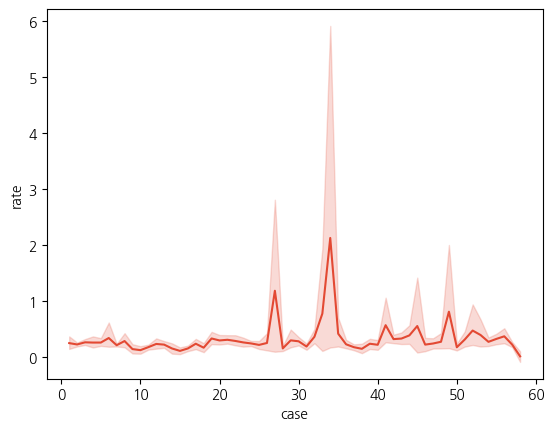

In [1406]:
sns.lineplot(data = train_df, x = 'case', y = 'rate');

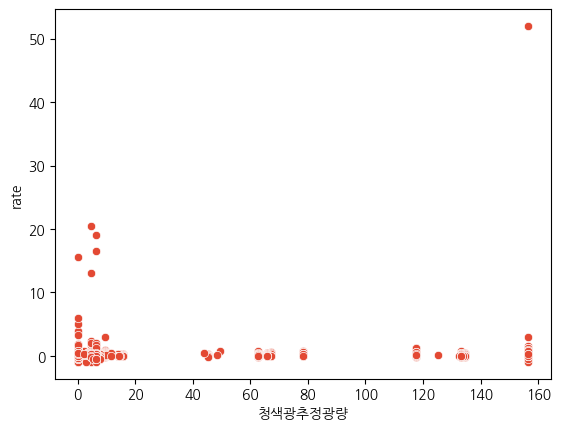

In [1407]:
# 청색광추정량, 블루LED동작강도
sns.scatterplot(data = train_df, x = '청색광추정광량', y = 'rate');

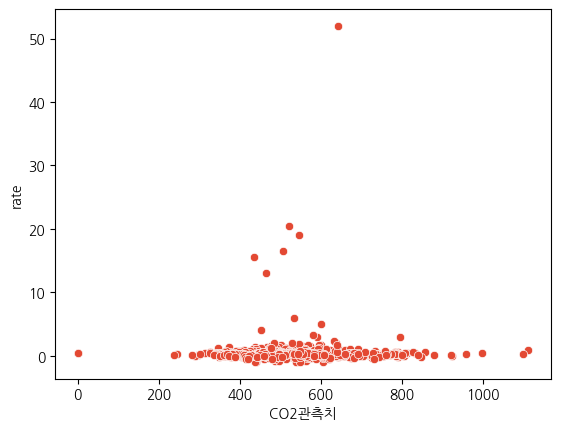

In [1408]:
sns.scatterplot(data = train_df, x = 'CO2관측치', y = 'rate');

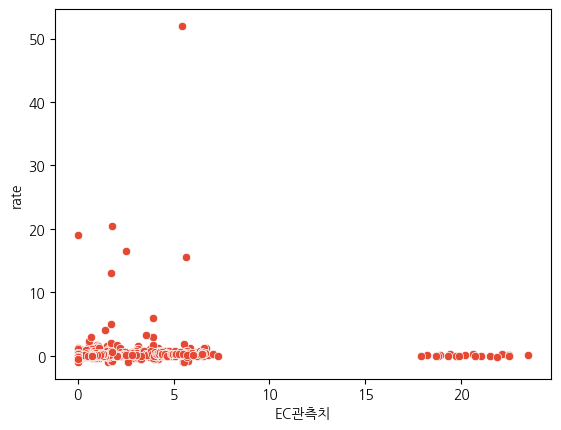

In [1409]:
sns.scatterplot(data = train_df, x = 'EC관측치', y = 'rate');

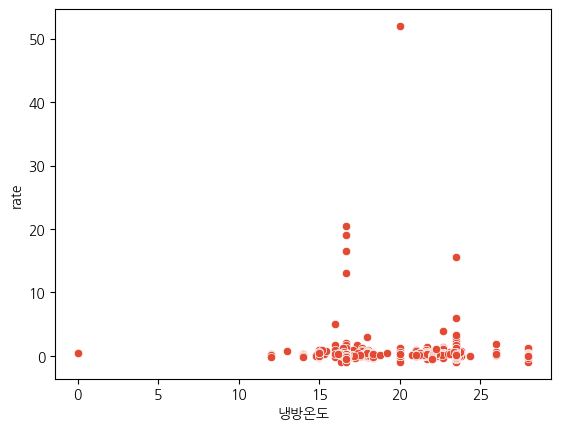

In [1410]:
sns.scatterplot(data = train_df, x = '냉방온도', y = 'rate');

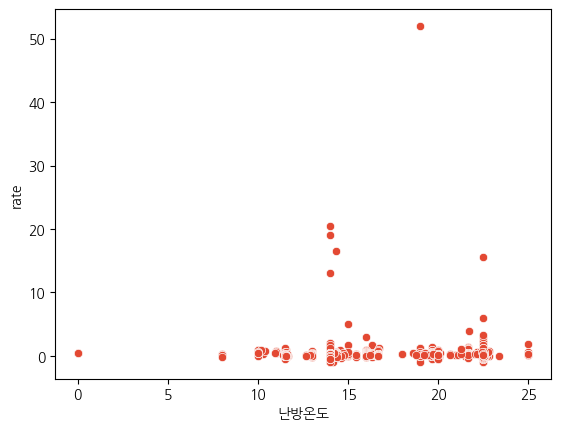

In [1411]:
sns.scatterplot(data = train_df, x = '난방온도', y = 'rate');

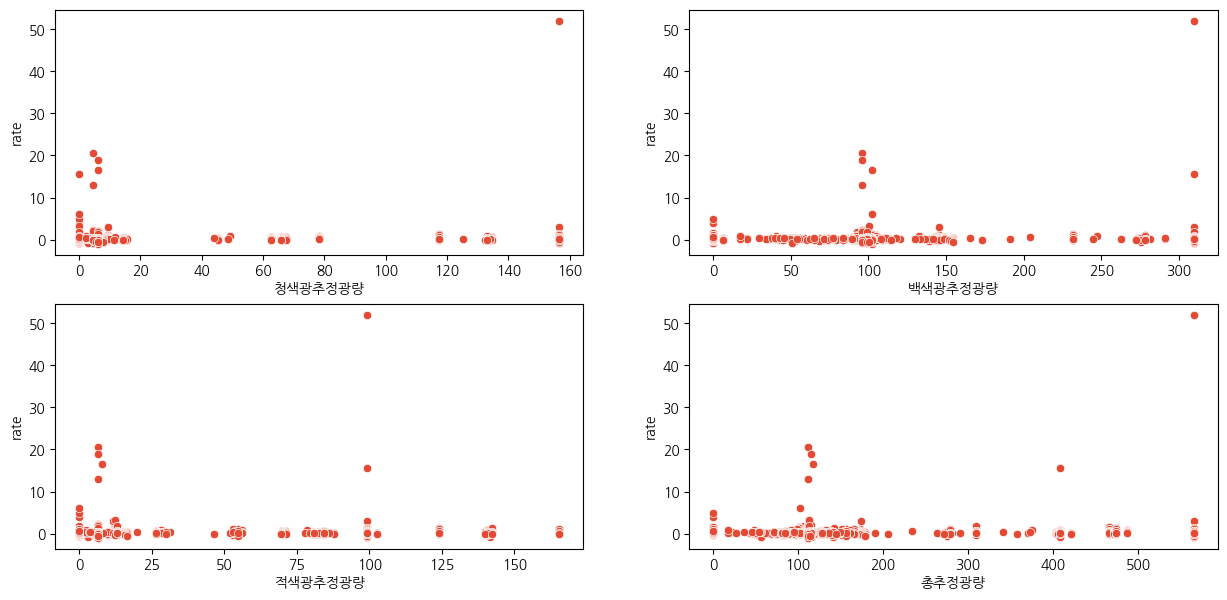

In [1412]:
sns.set_palette('RdYlGn')
fig, axs = plt.subplots(ncols = 2, nrows = 2, figsize=(15,7))
sns.scatterplot(data = train_df, x = '청색광추정광량', y = 'rate', ax = axs[0][0]);
sns.scatterplot(data = train_df, x = '백색광추정광량', y = 'rate', ax = axs[0][1]);
sns.scatterplot(data = train_df, x = '적색광추정광량', y = 'rate', ax = axs[1][0]);
sns.scatterplot(data = train_df, x = '총추정광량', y = 'rate', ax = axs[1][1]);

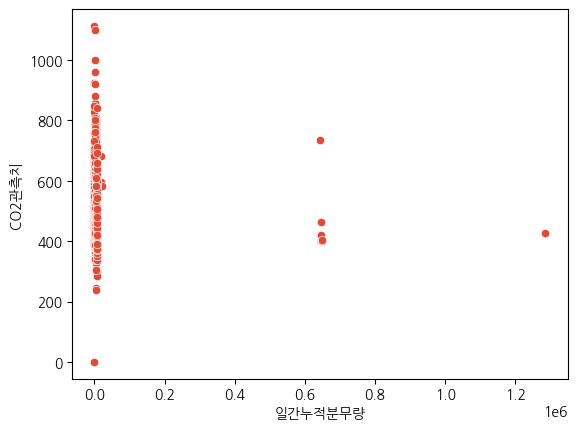

In [1413]:
sns.scatterplot(data = train_df, x = '일간누적분무량', y = 'CO2관측치');

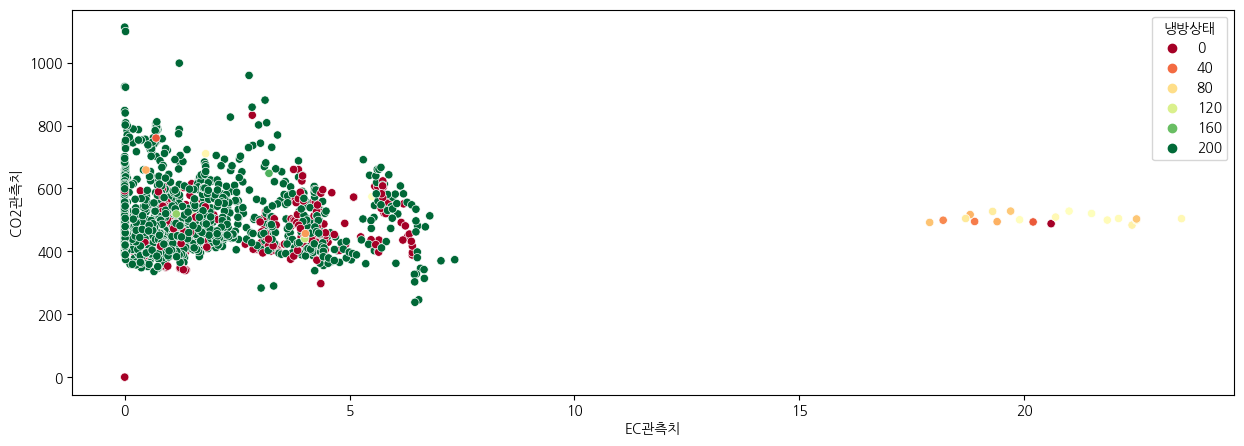

In [1414]:
# EC, CO2
plt.figure(figsize=(15, 5))
sns.scatterplot(data = train_df, x = 'EC관측치', y = 'CO2관측치', hue = '냉방상태', palette = 'RdYlGn');

In [1415]:
train_df.nunique().sort_values()[:10]

난방작동남은시간        1
펌프상태            1
난방상태            1
year            2
내부유동팬상태         2
외부환기팬상태         4
내부유동팬작동남은시간     4
펌프작동남은시간        6
month           9
카메라상태          21
dtype: int64

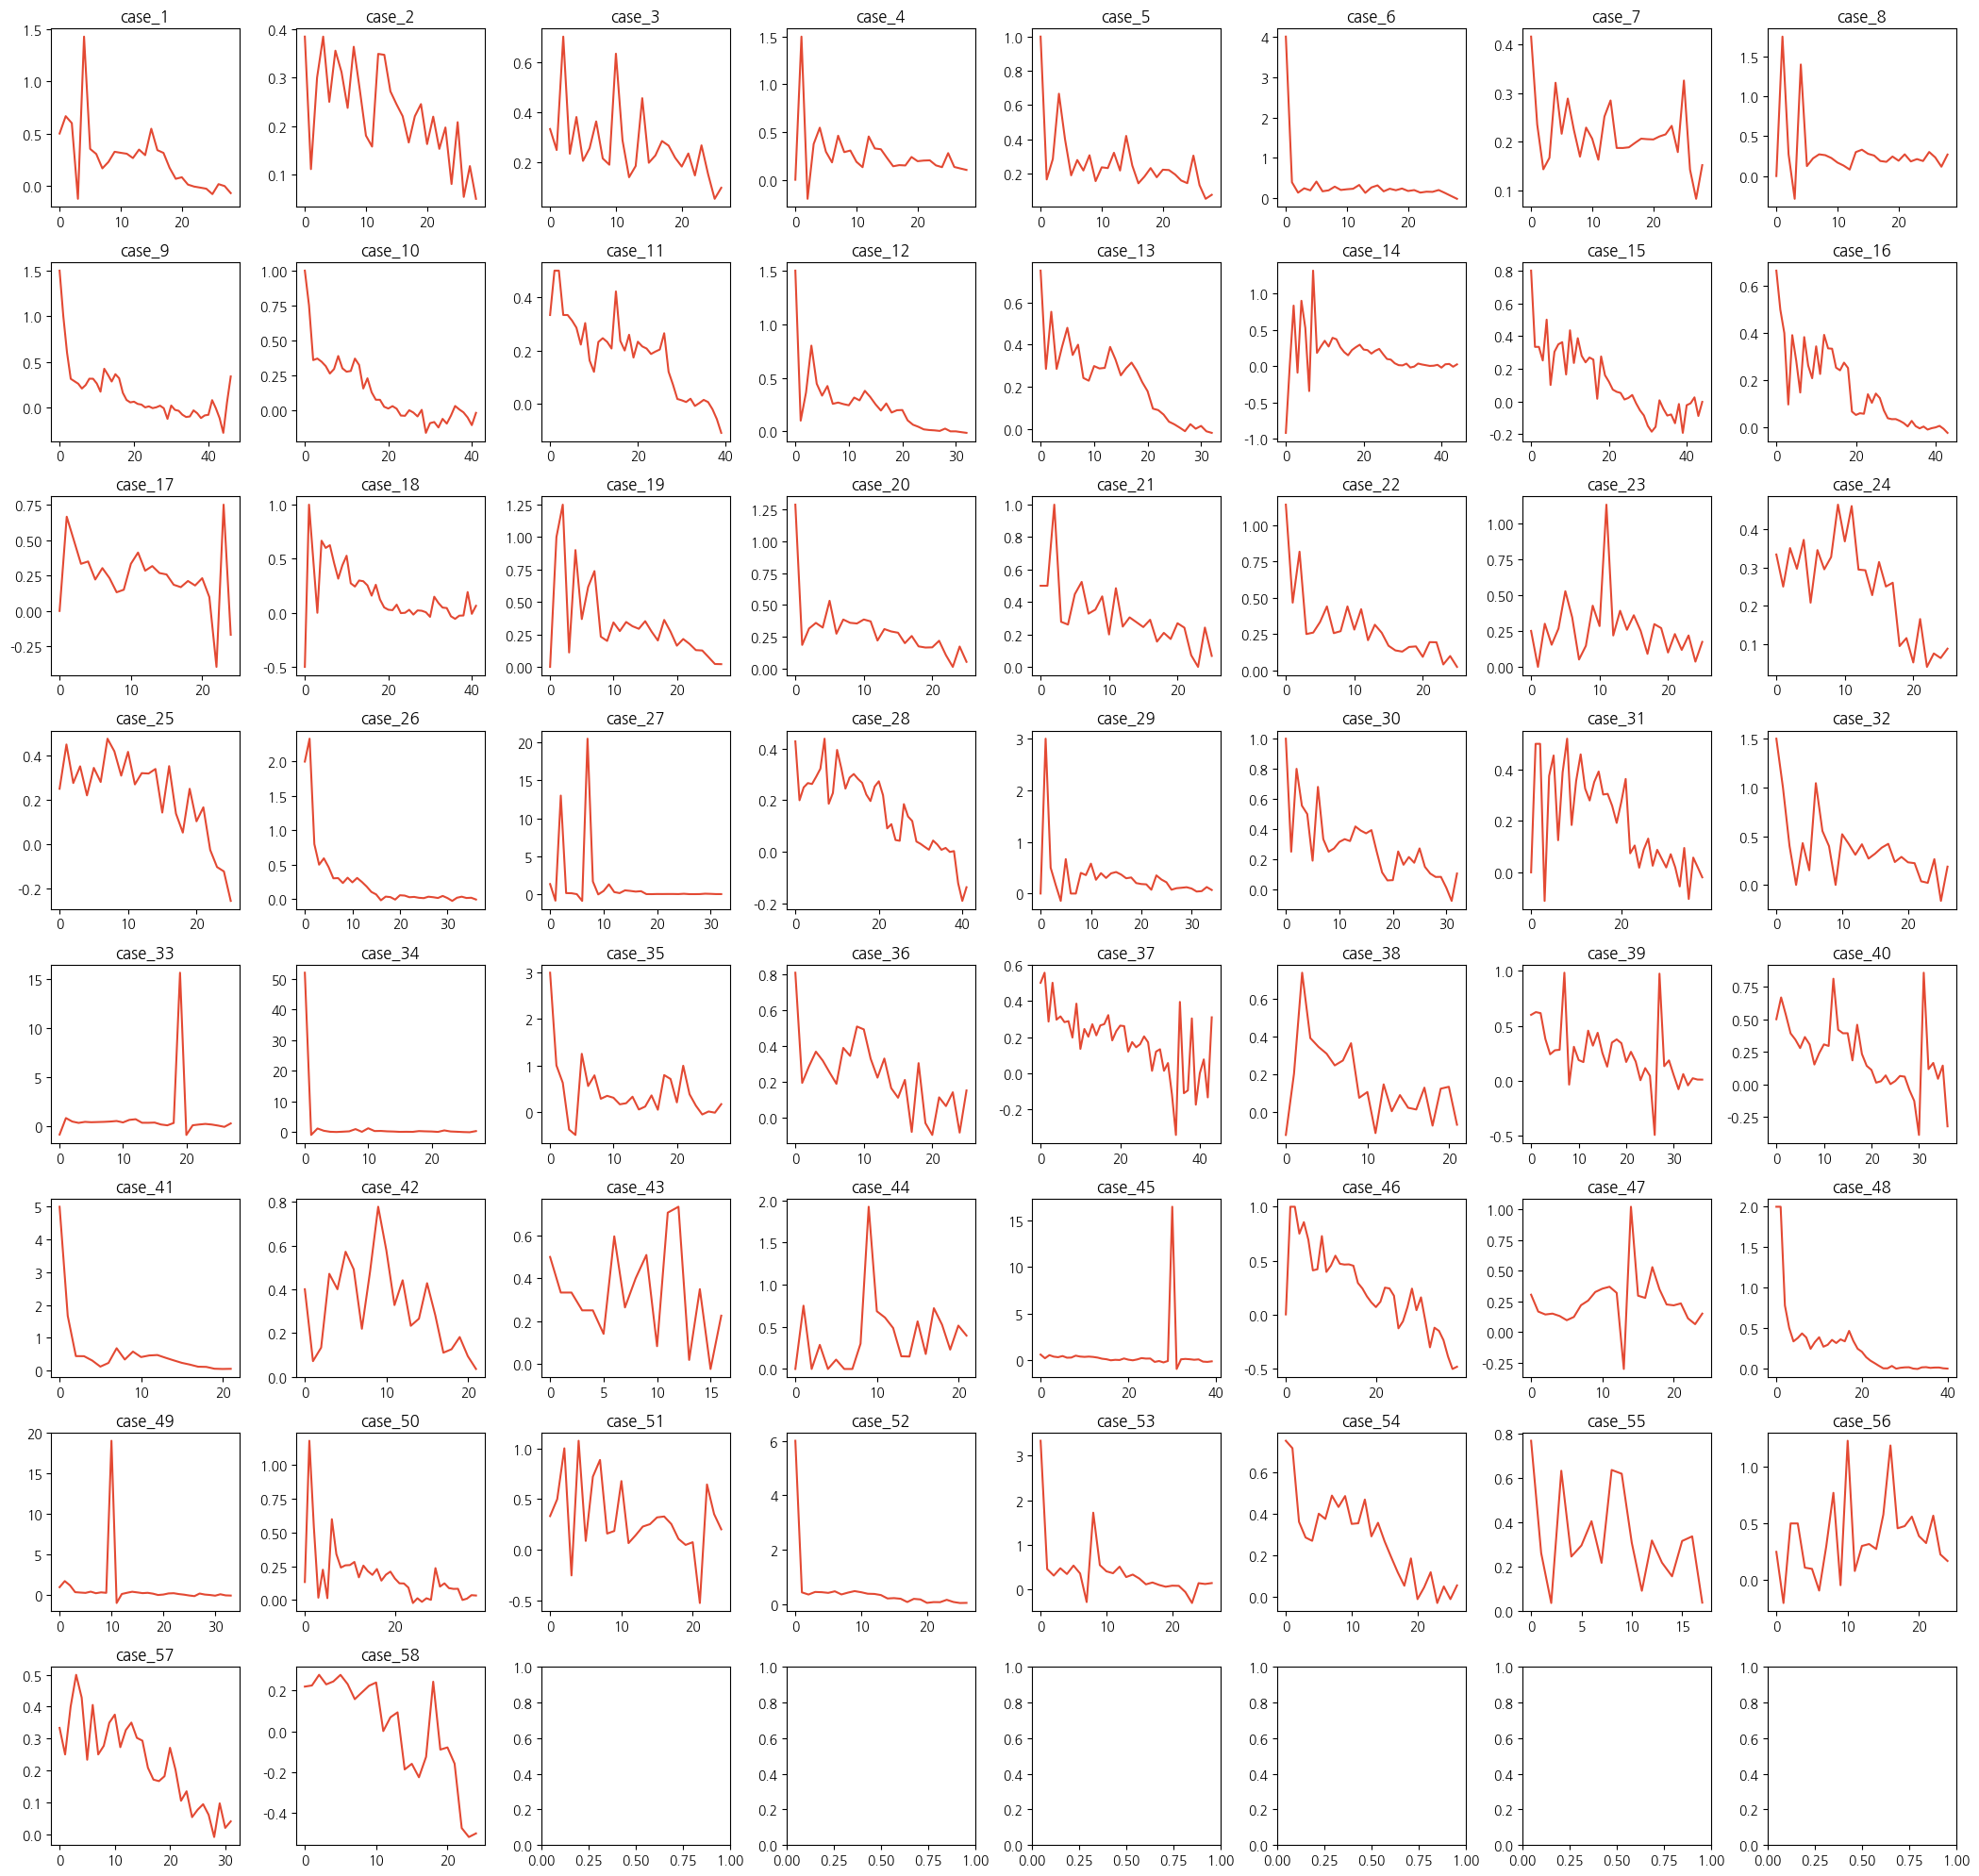

In [1416]:
fig, axs = plt.subplots(nrows=8, ncols=8, figsize=(21, 20))
axs = axs.ravel(order='C')
for i, v in enumerate(train_df["case"].unique()):
    axs[i].plot(train_df["rate"][train_df["case"] == v].reset_index(drop=True))
    axs[i].set_title(f"case_{v}")
plt.tight_layout()
plt.show()

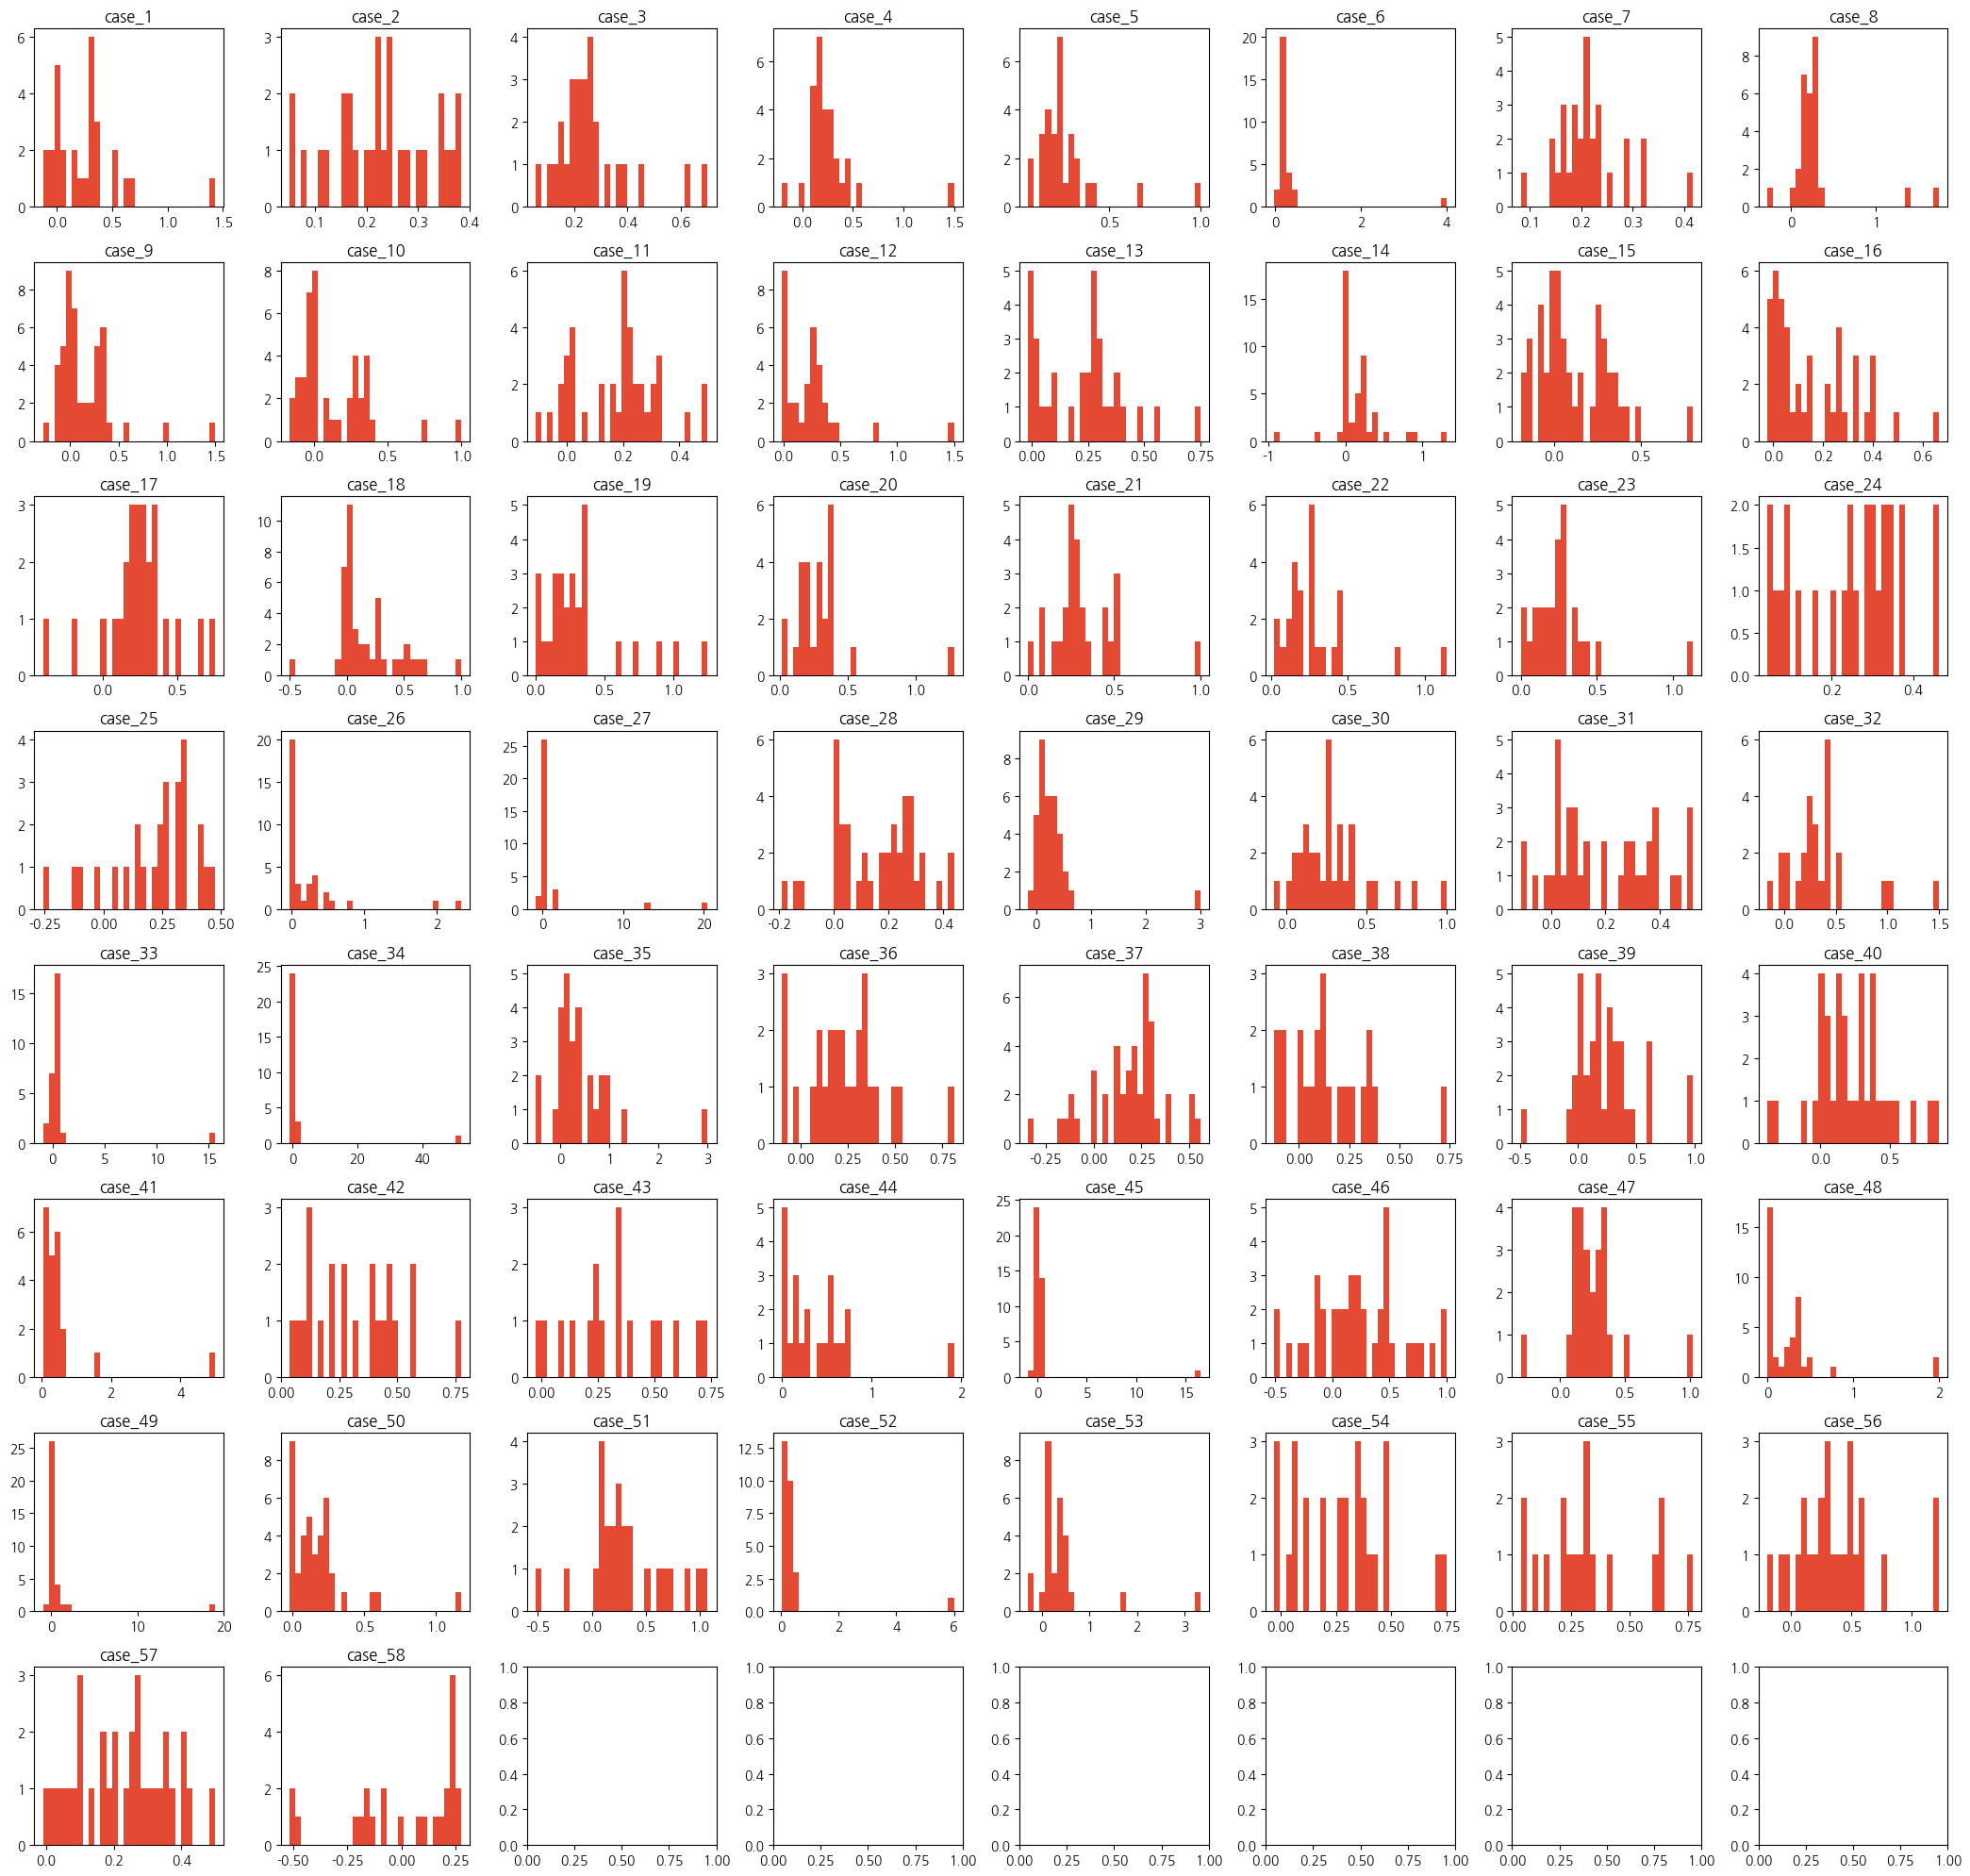

In [1417]:
fig, axs = plt.subplots(nrows=8, ncols=8, figsize=(21, 20))
axs = axs.ravel(order='C')
for i, v in enumerate(train_df["case"].unique()):
    axs[i].hist(train_df["rate"][train_df["case"] ==
                v].reset_index(drop=True), bins=30)
    axs[i].set_title(f"case_{v}")
plt.tight_layout()
plt.show()


## 3. 결측치

### 결측치 확인

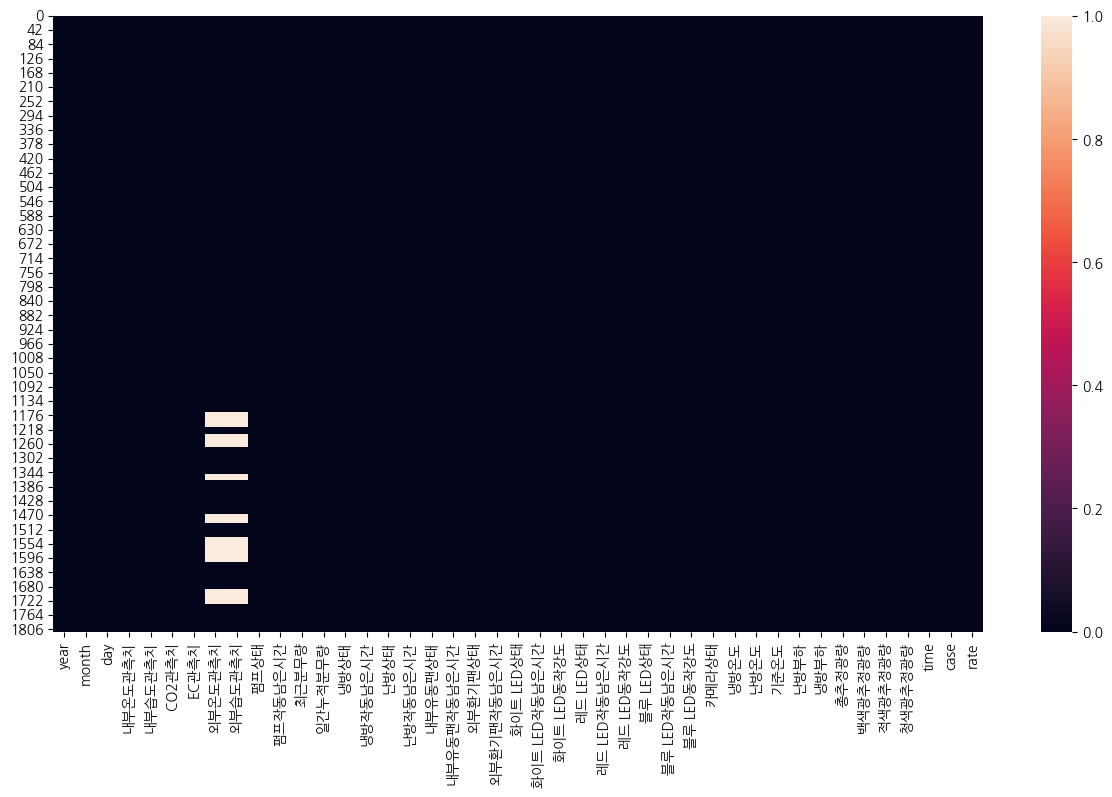

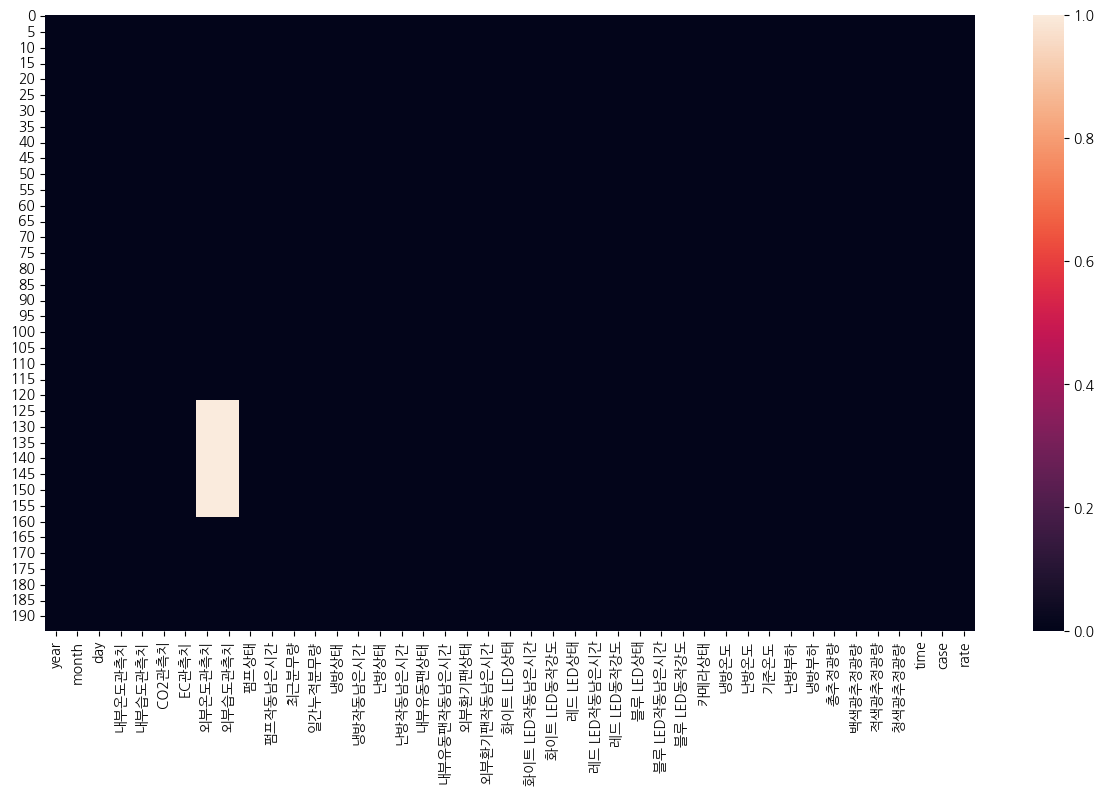

In [1418]:
plt.figure(figsize=(15, 8))
sns.heatmap(train_df.isnull())
plt.show()

plt.figure(figsize=(15, 8))
sns.heatmap(test_df.isnull())
plt.show()


In [1419]:
# 결측치
train_df.isnull().sum()[train_df.isnull().sum() > 0]


외부온도관측치    241
외부습도관측치    241
dtype: int64

In [1420]:
# 결측치
test_df.isnull().sum()[test_df.isnull().sum() > 0]


외부온도관측치    37
외부습도관측치    37
dtype: int64

### 결측치 처리

In [1421]:
train_df = train_df.fillna(method="bfill")
test_df = test_df.fillna(method="bfill")

train_df.shape, test_df.shape

((1813, 43), (195, 43))

In [1422]:
train_df.isnull().sum().sum(), test_df.isnull().sum().sum()

(0, 0)

## 4. 파생변수

### Season

In [1423]:
def season(x):
    if x in [3, 4, 5]:
        return 'spring'
    elif x in [6, 7, 8]:
        return 'summer'
    elif x in [9, 10, 11]:
        return 'fall'
    elif x in [12, 1, 2]:
        return 'winter'
    else:
        return np.nan

In [1424]:
train_df['Season'] = train_df['month'].apply(season)
train_df['Season'].value_counts()

spring    1159
summer     345
winter     234
fall        75
Name: Season, dtype: int64

In [1425]:
test_df['Season'] = test_df['month'].apply(season)
test_df['Season'].value_counts()

spring    140
winter     29
summer     26
Name: Season, dtype: int64

In [1426]:
train_df.select_dtypes(include = 'object').columns

Index(['Season'], dtype='object')

In [1427]:
train_df = pd.get_dummies(train_df)
test_df = pd.get_dummies(test_df)
test_df['fall'] = 0
train_df.shape, test_df.shape

((1813, 47), (195, 47))

In [1428]:
# train_df['growth_day'] = 

In [1429]:
train_df.select_dtypes(include = 'object').columns

Index([], dtype='object')

In [1430]:
test_df.select_dtypes(include='object').columns

Index([], dtype='object')

## 5. 필요없는 변수 제거

In [1431]:
train_df

,year,month,day,내부온도관측치,내부습도관측치,CO2관측치,EC관측치,외부온도관측치,외부습도관측치,펌프상태,펌프작동남은시간,최근분무량,일간누적분무량,냉방상태,냉방작동남은시간,난방상태,난방작동남은시간,내부유동팬상태,내부유동팬작동남은시간,외부환기팬상태,외부환기팬작동남은시간,화이트 LED상태,화이트 LED작동남은시간,화이트 LED동작강도,레드 LED상태,레드 LED작동남은시간,레드 LED동작강도,블루 LED상태,블루 LED작동남은시간,블루 LED동작강도,카메라상태,냉방온도,난방온도,기준온도,난방부하,냉방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량,time,case,rate,Season_fall,Season_spring,Season_summer,Season_winter
0,2021,2,18,22.299999,26.700001,397.0,0.917129,19.100000,10.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,129.0,100.0,201.0,132.0,0.0,201.0,133.5,0.0,0.0,21.663786,19.663786,20.705163,0.0,1.000004,0.0000,0.00000,0.0000,0.00000,0,1,0.50000,0,0,0,1
1,2021,2,19,21.900000,33.299999,357.0,0.910134,17.700001,11.100000,0.0,0.0,769.0,6901.71,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,251.0,100.0,201.0,252.0,61.0,201.0,253.0,5.0,0.0,21.665922,19.665922,20.665922,0.0,0.000000,0.0000,0.00000,0.0000,0.00000,1,1,0.66667,0,0,0,1
2,2021,2,20,22.150001,31.349999,354.0,0.910134,18.100000,13.400000,0.0,0.0,769.0,6132.71,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,249.0,100.0,201.0,252.0,61.0,201.0,255.0,5.0,0.0,21.666866,19.666866,20.666866,0.0,0.000000,0.0000,0.00000,0.0000,0.00000,2,1,0.60000,0,0,0,1
3,2021,2,21,23.600000,23.100000,349.0,0.910134,20.200001,20.299999,0.0,0.0,769.0,6139.14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.5,201.0,251.0,100.0,201.0,252.0,61.0,201.0,255.0,5.0,0.0,21.665137,19.665137,20.665137,0.0,1.999998,0.0000,0.00000,0.0000,0.00000,3,1,-0.12500,0,0,0,1
4,2021,2,22,24.650001,44.799999,373.0,0.910134,22.000000,22.500000,0.0,0.0,769.0,5766.20,201.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,252.0,100.0,201.0,253.5,61.0,201.0,255.0,5.0,0.0,21.675179,19.675179,20.675179,0.0,3.999996,0.0000,0.00000,0.0000,0.00000,4,1,1.42857,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1808,2022,6,11,23.799999,65.800003,459.0,0.011633,25.200001,41.500000,0.0,0.0,769.0,6152.00,201.0,3567.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,101.0,31.0,201.0,103.0,4.0,201.0,105.0,4.0,0.0,16.666686,14.003576,15.428755,0.0,40.500002,111.7692,95.91710,6.6192,6.26600,20,58,-0.07888,0,0,1,0
1809,2022,6,12,23.500000,64.199997,505.0,0.010857,25.200001,41.500000,0.0,0.0,769.0,6152.00,201.0,3566.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,103.0,31.0,201.0,105.0,4.0,201.0,107.0,3.0,0.0,16.664980,14.004000,15.425492,0.0,40.500002,111.7692,95.91710,6.6192,4.69950,21,58,-0.15838,0,0,1,0
1810,2022,6,13,23.250000,63.200001,415.5,0.010082,25.200001,41.500000,0.0,0.0,769.0,6152.00,201.0,3567.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,101.0,32.0,201.0,103.0,4.0,201.0,105.0,4.0,0.0,16.662264,14.001588,15.433483,0.0,38.999996,111.3481,95.91710,6.6192,5.48275,22,58,-0.47374,0,0,1,0
1811,2022,6,14,23.299999,63.200001,479.0,0.010082,25.200001,41.500000,0.0,0.0,769.0,6152.00,201.0,3565.0,0.0,0.0,0.0,0.0,0.0,0.0,201.0,102.0,32.0,201.0,104.0,4.0,201.0,106.0,4.0,0.0,16.666138,14.002086,15.426235,0.0,36.999998,111.7692,99.01120,6.6192,6.26600,23,58,-0.51767,0,0,1,0


In [1432]:
drop_columns = [
    
    "year", "day", 
    "외부온도관측치", "외부습도관측치",                     # 외부
    "카메라상태",
    "펌프상태", "난방상태", "난방작동남은시간",             # unique
]

train_df = train_df.drop(drop_columns, axis=1)
test_df = test_df.drop(drop_columns, axis=1)

train_df.shape, test_df.shape

((1813, 39), (195, 39))

In [1433]:
train_df.corr()['rate'].sort_values(ascending = False)[:5]

rate             1.000000
Season_winter    0.072409
총추정광량            0.058203
블루 LED동작강도       0.053690
청색광추정광량          0.051424
Name: rate, dtype: float64

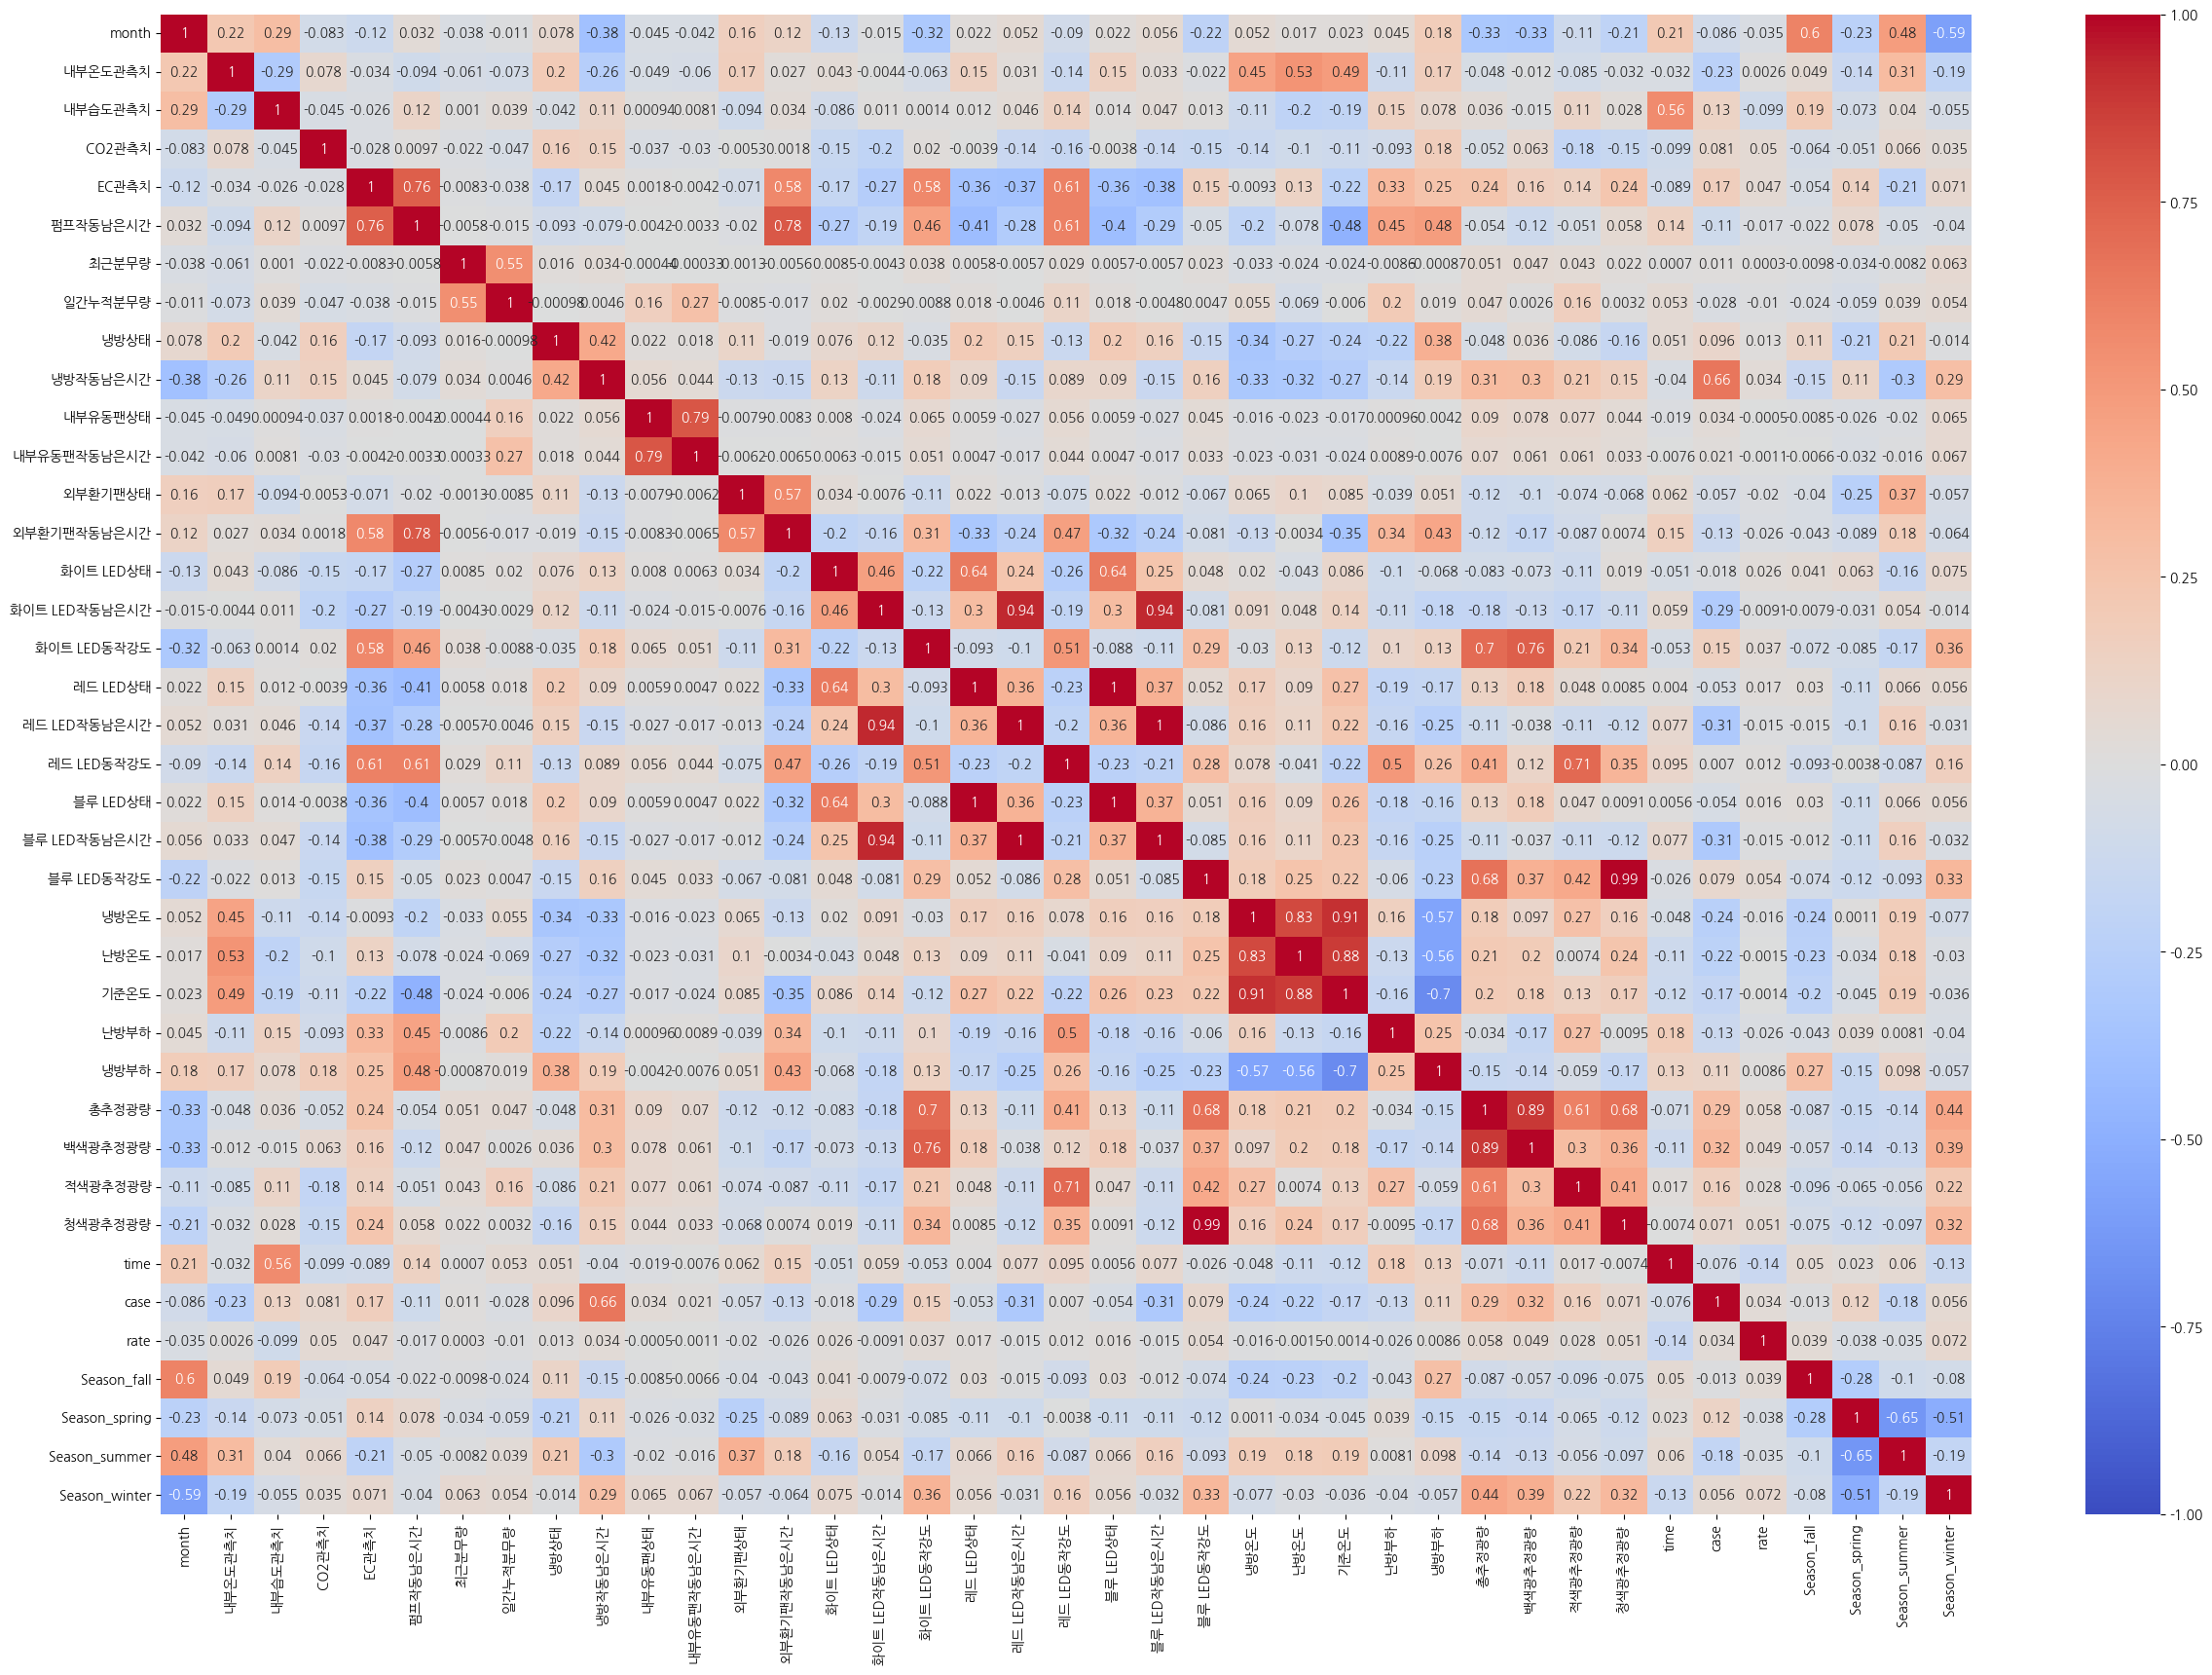

In [1434]:
plt.figure(figsize=(30,20))
sns.heatmap(train_df.corr(), vmin=-1, vmax=1, cmap='coolwarm', annot=True)
plt.show();

In [1435]:
X_train = train_df.drop(columns = 'rate')
y_train = train_df['rate']

X_test = test_df.drop(columns='rate')
y_test = test_df['rate']

In [1436]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1813, 38), (195, 38), (1813,), (195,))

In [1437]:
sc = scaler
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [1438]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

In [1439]:
y_train = torch.FloatTensor(y_train).reshape(-1,1)

## 모델 생성 및 학습

In [1440]:
linear1 = torch.nn.Linear(X_train.shape[1], 512, bias=True)
linear2 = torch.nn.Linear(512, 512, bias=True)
linear3 = torch.nn.Linear(512, 512, bias=True)
linear4 = torch.nn.Linear(512, 512, bias=True)
linear5 = torch.nn.Linear(512, 1, bias=True)
relu = torch.nn.ReLU()
dropout = torch.nn.Dropout(p=0.1)

In [1441]:
model = torch.nn.Sequential(linear1,relu,
                            linear2,relu,
                            linear3,relu,
                            linear4, relu,
                            linear5).to(device)

In [1442]:
torch.nn.init.xavier_normal_(linear1.weight)
torch.nn.init.xavier_normal_(linear2.weight)
torch.nn.init.xavier_normal_(linear3.weight)
torch.nn.init.xavier_normal_(linear4.weight)
torch.nn.init.xavier_normal_(linear5.weight)

Parameter containing:
tensor([[ 0.0769, -0.1199,  0.0563, -0.0429, -0.0175, -0.1088,  0.1373, -0.0283,
         -0.0610, -0.0307, -0.0354,  0.0219,  0.0753, -0.0634, -0.0837, -0.0297,
         -0.0223, -0.0624, -0.0847, -0.0752,  0.0401, -0.0521,  0.0415, -0.0935,
          0.0082, -0.0047, -0.0058, -0.0249,  0.0405,  0.0531, -0.0719,  0.0151,
         -0.0292, -0.0178,  0.0699,  0.0284, -0.0904, -0.0811,  0.0029, -0.0496,
          0.0498, -0.1149, -0.0435,  0.1398, -0.0167, -0.0601, -0.1094,  0.0311,
          0.0375,  0.1020,  0.0734,  0.0774,  0.0356, -0.1266,  0.0327,  0.0238,
          0.0332,  0.0437, -0.0770, -0.0097, -0.0092,  0.0031,  0.0757, -0.0005,
          0.0812, -0.0857,  0.0547,  0.0232, -0.0648,  0.0508,  0.0705,  0.0814,
         -0.0156,  0.1373,  0.0718, -0.0779,  0.0220, -0.0558, -0.0608, -0.0066,
          0.0505, -0.0055,  0.0025,  0.0238, -0.1099,  0.0624, -0.0821,  0.0254,
          0.0938, -0.0077, -0.0669, -0.0110, -0.0660, -0.0323,  0.0907,  0.0204,
      

In [1443]:
loss_fn = torch.nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [1444]:
def get_stacking_ml_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
    
    train_fold_pred = np.zeros((X_train_n.shape[0], 1))
    test_pred = np.zeros((X_test_n.shape[0], n_folds))
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n, y_train_n)):
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]
        
        model.fit(X_tr, y_tr)
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        test_pred[:, folder_counter] = model.predict(X_test_n)
        
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    return train_fold_pred, test_pred_mean

In [1445]:
from sklearn.metrics import mean_squared_error

In [1446]:
# 모델 학습
for epoch in range(500):
    
    # grad 초기화
    optimizer.zero_grad()
    
    # H(x)
    hypothesis = model(X_train)
    
    # cost 계산
    cost = loss_fn(hypothesis, y_train)
    
    # cost로 H(x) 개선
    cost.backward()
    optimizer.step()

    # epoch 50마다 cost, error 찍기
    if epoch % 50 == 0:
        # mape
        err = 100 * sum((y_train-hypothesis) ** 2) / len(y_train)
        
        # err = mean_squared_error(y_train, output.int())
        print(f"Epoch: {epoch} Cost: {cost:.4f} Error: {err.item():.4f}")


Epoch: 0 Cost: 1523.3844 Error: 152338.1406
Epoch: 50 Cost: 2.5960 Error: 259.5977
Epoch: 100 Cost: 2.0026 Error: 200.2594
Epoch: 150 Cost: 1.1048 Error: 110.4788
Epoch: 200 Cost: 0.3518 Error: 35.1850
Epoch: 250 Cost: 0.1897 Error: 18.9711
Epoch: 300 Cost: 0.1598 Error: 15.9799
Epoch: 350 Cost: 0.1551 Error: 15.5129
Epoch: 400 Cost: 0.1514 Error: 15.1415
Epoch: 450 Cost: 0.1496 Error: 14.9639


In [1447]:
# model.eval()
# with torch.no_grad():
#     val_pred = model(X_val)

In [1448]:
y_pred = model(X_test)
y_pred[:5]

tensor([[ 0.0062],
        [-0.1083],
        [-0.1820],
        [-0.1597],
        [ 0.2466]], grad_fn=<SliceBackward0>)

In [1449]:
y_pred = y_pred.detach().numpy()

In [1450]:
y_pred = y_pred.flatten()

In [1451]:
submit_path = f'{base_path}/sample_submission'

submit_df1 = pd.read_csv(f"{submit_path}/TEST_01.csv")
submit_df1.head()

,시간,rate
0,2021-03-27 00:00:00,-0.188505
1,2021-03-28 00:00:00,-0.173681
2,2021-03-29 00:00:00,0.047399
3,2021-03-30 00:00:00,-0.011647
4,2021-03-31 00:00:00,0.124785


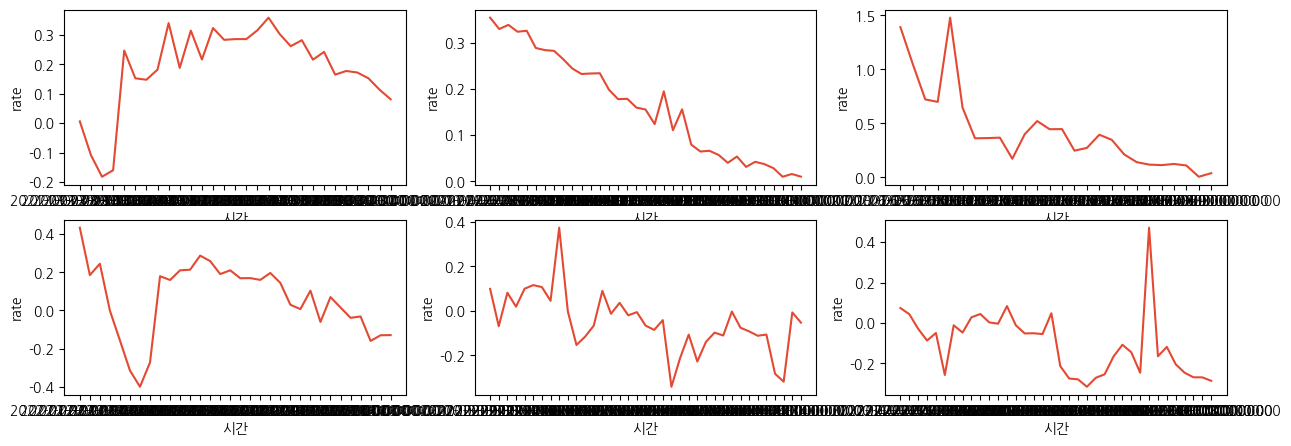

In [1461]:
fig, axs = plt.subplots(ncols = 3, nrows = 2, figsize=(15, 5));
sns.lineplot(data = submit_df1, x = '시간', y = 'rate', ax = axs[0][0]);
sns.lineplot(data = submit_df2, x = '시간', y = 'rate', ax = axs[0][1]);
sns.lineplot(data = submit_df3, x = '시간', y = 'rate', ax = axs[0][2]);
sns.lineplot(data = submit_df4, x = '시간', y = 'rate', ax = axs[1][0]);
sns.lineplot(data = submit_df5, x = '시간', y = 'rate', ax = axs[1][1]);
sns.lineplot(data = submit_df6, x = '시간', y = 'rate', ax = axs[1][2]);

In [1452]:
# ((29, 2), (35, 2), (26, 2), (32, 2), (37, 2), (36, 2))

submit_path = f'{base_path}/sample_submission'

submit_df1 = pd.read_csv(f"{submit_path}/TEST_01.csv")
submit_df1["rate"] = y_pred[:29]
submit_df1.to_csv(f"{submit_path}/TEST_01.csv", index=False)

submit_df2 = pd.read_csv(f"{submit_path}/TEST_02.csv")
submit_df2["rate"] = y_pred[29:29+35]
submit_df2.to_csv(f"{submit_path}/TEST_02.csv", index=False)

submit_df3 = pd.read_csv(f"{submit_path}/TEST_03.csv")
submit_df3["rate"] = y_pred[29+35:29+35+26]
submit_df3.to_csv(f"{submit_path}/TEST_03.csv", index=False)

submit_df4 = pd.read_csv(f"{submit_path}/TEST_04.csv")
submit_df4["rate"] = y_pred[29+35+26:29+35+26+32]
submit_df4.to_csv(f"{submit_path}/TEST_04.csv", index=False)

submit_df5 = pd.read_csv(f"{submit_path}/TEST_05.csv")
submit_df5["rate"] = y_pred[29+35+26+32:29+35+26+32+37]
submit_df5.to_csv(f"{submit_path}/TEST_05.csv", index=False)

submit_df6 = pd.read_csv(f"{submit_path}/TEST_06.csv")
submit_df6["rate"] = y_pred[29+35+26+32+37:]
submit_df6.to_csv(f"{submit_path}/TEST_06.csv", index=False)


submit_df1.shape, submit_df2.shape, submit_df3.shape, submit_df4.shape, submit_df5.shape, submit_df6.shape

((29, 2), (35, 2), (26, 2), (32, 2), (37, 2), (36, 2))

In [1453]:
import zipfile
os.chdir(f'{base_path}/sample_submission/')
submission = zipfile.ZipFile(f"{submit_path}/submission_new.zip", 'w')
for path in test_target_files:
    path = path.split('/')[-1]
    submission.write(path)
submission.close()